## Get the data

In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qstools as qs
import qstools.indicators as qsi
import math
import re

from sklearn import metrics as skm
from scipy import stats 

import warnings
warnings.simplefilter('ignore')

In [2]:
cids_dmca = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK', 'USD']  # DM currency areas
cids_dmec = ['DEM', 'ESP', 'FRF', 'ITL', 'NLG']  # DM euro area countries
cids_latm = ['ARS', 'BRL', 'COP', 'CLP', 'MXN', 'PEN']  # Latam countries
cids_emea = ['HUF', 'ILS', 'PLN', 'RON', 'RUB', 'TRY', 'ZAR']  # EMEA countries
cids_emas = ['CNY', 'HKD', 'IDR', 'INR', 'KRW', 'MYR', 'PHP', 'SGD', 'THB', 'TWD']  # EM Asia countries
cids_dm = cids_dmca + cids_dmec
cids_em = cids_latm + cids_emea + cids_emas
cids = sorted(cids_dm + cids_em)

cids_eufx = ['CHF', 'HUF', 'NOK', 'PLN', 'RON', 'SEK']  # EUR benchmark
cids_g2fx = ['GBP', 'RUB', 'TRY']  # dual benchmark
cids_usfx = ['AUD', 'BRL', 'CAD', 'CLP', 'CNY', 'COP', 'EUR', 'IDR', 'ILS', 'INR', 'JPY', 'KRW', 'MYR',
             'MXN', 'NZD', 'PEN', 'PHP', 'SGD', 'THB', 'TWD', 'ZAR']  # USD benchmark
cids_fx = cids_usfx + cids_eufx + cids_g2fx 
cids_ffx = set(cids_fx) - set(['CNY', 'SGD'])

In [3]:
from_DB = True
path_to_feather = "..//data//feathers//"  # 
base_cats = ['FXXR', 'FXCRY', 'FXCRR']
add_cats = ['_NSA', '_VT10', '_VT10vGLB29', 'HvGDRB_NSA', 'HvGDRBvGLB29_NSA']
xcats = [base + add for add in add_cats for base in base_cats]

if from_DB:
    
    dbi = qsi.DownloadQuantamentalIndicators(username="rsueppel",
                                             host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                             password="l3oT7^WerjY#O!9EGqvL",
                                             database="qs_jpm_point_time")
    dfd_imp = dbi.get_xcat(cross_section = cids, xcat = xcats).reset_index(drop=True)    
    dfd_imp.to_feather(f'{path_to_feather}dfd_fx_xrcr.ftr')
        
else:
        
    dfd_imp = pd.read_feather(f'{path_to_feather}dfd_fx_xrcr.ftr')
    
dfd_fxzn = pd.read_feather(f'{path_to_feather}dfd_fxmacro_zn.ftr')

In [4]:
dfd_imp[['cid', 'cat']] = dfd_imp['ticker'].str.split('_', 1, expand=True)  # split string column
dfd_imp['real_date'] = pd.to_datetime(dfd_imp['real_date'])
dfd_imp.sort_values(['ticker', 'real_date'], inplace=True)

In [5]:
dfd = dfd_imp[['cid', 'cat', 'real_date', 'value']].append(dfd_fxzn)
dfd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4933931 entries, 1790991 to 2529171
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   cid        object        
 1   cat        object        
 2   real_date  datetime64[ns]
 3   value      float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 188.2+ MB


In [6]:
dfd['cat'].unique()

array(['FXCRRHvGDRB_NSA', 'FXCRRHvGDRBvGLB29_NSA', 'FXCRR_NSA',
       'FXCRR_VT10', 'FXCRR_VT10vGLB29', 'FXCRYHvGDRB_NSA',
       'FXCRYHvGDRBvGLB29_NSA', 'FXCRY_NSA', 'FXCRY_VT10',
       'FXCRY_VT10vGLB29', 'FXXRHvGDRB_NSA', 'FXXRHvGDRBvGLB29_NSA',
       'FXXR_NSA', 'FXXR_VT10', 'FXXR_VT10vGLB29',
       'XCPIH_SJA_P6M6ML6ARZN', 'XCPIC_SJA_P6M6ML6ARZN',
       'BXBGDPRATIO_NSA_12MMAZN', 'MTBGDPRATIO_NSA_12MMA_D1M1ML3ZN',
       'GROWTH_vBMZN', 'CREDITGROWTH_vBMZN', 'RIRvBM_NSAZN',
       'FXCRR_NSAZN', 'NEER_NSA_P1M1ML12ZNN', 'REER_NSA_P1M60ML1ZNN',
       'XBETAZNN', 'INF_PRESSURE_ZN', 'XBAL_STRENGTH_ZN',
       'PCREDIT_vBM_ZN', 'RIR_vBM_ZN', 'FXWEAK_ZN'], dtype=object)

In [7]:
cids_exp = cids_fx
xcats_exp = xcats  + list(dfd_fxzn['cat'].unique())

print('Missing xcats across df: ', set(xcats_exp) - set(dfd['cat'].unique()))  # any xcats missing
xcats_used = sorted(list(set(xcats_exp).intersection(set(dfd['cat'].unique()))))
for xcat in xcats_used:
    cids_xcat = dfd.loc[dfd['cat']==xcat, 'cid'].unique()
    print(f'Missing cids for {xcat}: ', set(cids_exp) - set(cids_xcat))  # any cross section missing?

Missing xcats across df:  set()
Missing cids for BXBGDPRATIO_NSA_12MMAZN:  set()
Missing cids for CREDITGROWTH_vBMZN:  set()
Missing cids for FXCRRHvGDRB_NSA:  set()
Missing cids for FXCRRHvGDRBvGLB29_NSA:  {'CNY', 'EUR'}
Missing cids for FXCRR_NSA:  set()
Missing cids for FXCRR_NSAZN:  set()
Missing cids for FXCRR_VT10:  set()
Missing cids for FXCRR_VT10vGLB29:  {'CNY', 'EUR'}
Missing cids for FXCRYHvGDRB_NSA:  set()
Missing cids for FXCRYHvGDRBvGLB29_NSA:  {'CNY', 'EUR'}
Missing cids for FXCRY_NSA:  set()
Missing cids for FXCRY_VT10:  set()
Missing cids for FXCRY_VT10vGLB29:  {'CNY', 'EUR'}
Missing cids for FXWEAK_ZN:  set()
Missing cids for FXXRHvGDRB_NSA:  set()
Missing cids for FXXRHvGDRBvGLB29_NSA:  {'CNY', 'EUR'}
Missing cids for FXXR_NSA:  set()
Missing cids for FXXR_VT10:  set()
Missing cids for FXXR_VT10vGLB29:  {'CNY', 'EUR'}
Missing cids for GROWTH_vBMZN:  set()
Missing cids for INF_PRESSURE_ZN:  set()
Missing cids for MTBGDPRATIO_NSA_12MMA_D1M1ML3ZN:  set()
Missing cids fo

## Functions

In [8]:
def daily_to_monthly(df, cids=None, xcats=None, sum_cats=None, start='2000-01-01'):
    """Convert daily standard df to monthly frequence with eop default"""
    
    xcats_in_df = df['cat'].unique()
    if xcats is None:
        xcats = sorted(xcats_in_df)
    else:
        print(f'Missing xcats: ', set(xcats) - set(xcats_in_df))
        xcats = sorted(list(set(xcats).intersection(set(xcats_in_df))))
        df = df[df['cat'].isin(xcats)]
    
    cids_in_df = df['cid'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        df = df[df['cid'].isin(cids)]
        
    eop_cats = list(set(xcats) - set(sum_cats)) if sum_cats is not None else all_cats

    if sum_cats is not None:
        df_sum = df[df['cat'].isin(sum_cats)].groupby(['cid', 'cat']).resample('M', on='real_date').sum()
    else:
        df_sum = None

    if len(eop_cats) > 0:
        df_eop = df[df['cat'].isin(eop_cats)].groupby(['cid', 'cat']).resample('M', on='real_date').last().loc[:, ['value']]
    else:
        df_eop = None

    return pd.concat([df_sum, df_eop]).reset_index()[['cid', 'cat', 'real_date', 'value']]

In [9]:
def znscore(df, xcats, cids = None, start = '2000-01-01', pw=0, thresh = None, signs=None):
    dfx = df.loc[(df['real_date'] >= pd.to_datetime(start)), ]
    
    if signs is None:
        signs = [1] * len(xcats)
    
    cids_in_df = dfx['cid'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cid'].isin(cids)]

    dfzn = pd.DataFrame(columns = df.columns)
    for xcat, sign in zip(xcats, signs):
        dfxx = dfx[(dfx['cat'] == xcat)].pivot(index='real_date', columns='cid', values='value')
        pan_mabs = dfxx.abs().mean()  # panel mean absolute value
        cid_mabs = dfxx.apply(lambda x: np.mean(abs(x)), axis=0)  # cross-sectional mean absolute values
        dfxa = sign * dfxx / (pw * pan_mabs + (1-pw) * cid_mabs)  # weighted average of panel and cs means
        if thresh is not None:
            dfxa = dfxa.clip(lower = -thresh, upper = thresh)
        dfxa = dfxa.unstack().reset_index().rename({0 : 'value'}, axis=1)
        dfxa['cat'] = xcat + 'ZN' if sign == 1 else xcat + 'ZNN'
        dfzn = dfzn.append(dfxa[df.columns])
    return dfzn.reset_index(drop=True)

In [10]:
def blacklist_df(df, xcat, black):
    """Return dataframe that excludes black list periods for cross sections"""

    ind_remove = []
    for key, dates in black.items():
        filt0 = df['cat'] == xcat
        filt1 = df['cid'] == key
        filt2 = df['real_date'] > pd.to_datetime(dates[0]) 
        filt3 = df['real_date'] <= pd.to_datetime(dates[1])        
        ind_remove += df.index[filt1 & filt2 & filt3 & filt0].tolist()

    return df.iloc[~df.index.isin(ind_remove), :]

In [47]:
def pp_stats(df, cat_dep, cat_exp, cids, start = '2002-01-01', end = None, exp_lag = 1, black = None):
    """Key stats of predictive relations between explanatory and dependent in a panel"""
    
    if end is None:
        end = df['real_date'].max()

    filt1 = df['cat'].isin([cat_dep, cat_exp])
    filt2 = df['real_date'] >= pd.to_datetime(start)
    filt3 = df['real_date'] <= pd.to_datetime(end)
    filt4 = df['cid'].isin(cids)

    dfx = df[ filt1 & filt2 & filt3 & filt4]

    cids_in_dep = dfx[dfx['cat']==cat_dep]['cid'].unique()
    print(f'Missing dependent cross sections: ', set(cids) - set(cids_in_dep))
    cids_in_exp = dfx[dfx['cat']==cat_dep]['cid'].unique()
    print(f'Missing explanatory cross sections: ', set(cids) - set(cids_in_exp))
    cids = sorted(list(set(cids_in_dep).intersection(set(cids_in_exp))))                    
    dfx = dfx[dfx['cid'].isin(cids)]

    if black is not None:
        dfx = blacklist_df(dfx, cat_dep, black = black)

    dfw = dfx.pivot(index=['cid', 'real_date'], columns='cat', values ='value')
    dfw[cat_exp] = dfw[cat_exp].groupby(level=0).shift(exp_lag)  # lag explanatory
    dfw = dfw.dropna()

    statms = ['accuracy', 'bal_accuracy', 'f1_score', 'pearson', 'pearson_prob', 'kendall', 'kendall_prob']
    df_out = pd.DataFrame(index=['Panel', 'Average'] + cids, columns=statms)

    for cid in (cids + ['Panel']):
            if cid in cids:
                df_cid = dfw.loc[cid, ]
            else:
                df_cid = dfw

            dep_sign, exp_sign = np.sign(df_cid[cat_dep]), np.sign(df_cid[cat_exp])
            df_out.loc[cid, 'accuracy'] = skm.accuracy_score(dep_sign, exp_sign)
            df_out.loc[cid, 'bal_accuracy'] = skm.balanced_accuracy_score(dep_sign, exp_sign)
            df_out.loc[cid, 'f1_score'] = skm.f1_score(dep_sign, exp_sign, average='weighted')

            dep_val, exp_val = df_cid[cat_dep], df_cid[cat_exp]
            df_out.loc[cid, ['kendall', 'kendall_prob']] = stats.kendalltau(dep_val, exp_val)
            df_out.loc[cid, ['pearson', 'pearson_prob']] = stats.pearsonr(dep_val, exp_val)
            
    df_out.loc['Average', : ] = df_out.loc[cids, :].mean()
    
    return df_out

In [63]:
def weighted_zn(df, xcats, wgts=None, cids=None, gname='GROUP_ZN', re_zn = True):
    """Weighted combination of zn-scores"""
    
    if wgts is None:
        wgts = [1/len(xcats)]*len(xcats)
    
    dfx = df[df['cat'].isin(xcats)]
    cids_in_df = dfx['cid'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cid'].isin(cids)]

    dfx_piv = dfx.pivot(index=['cid', 'real_date'], columns='cat', values='value')

    dfxx = pd.DataFrame(np.dot(dfx_piv[xcats], wgts), index=dfx_piv.index).reset_index().rename({0 : 'value'}, axis=1)
    if re_zn:
        dfxx['value'] = dfxx['value'] / dfxx['value'].abs().mean()
    dfxx['cat'] = gname
    return dfxx[df.columns]

In [223]:
def naiveMonthlyPnl(df, xr, sigs, cids, asd = 10, dig = False, start = None, end = None, black = None, name='PNL'):
    """Simple PnLs based on monthly target returns and list signals (to be lagged internally)"""
    
    if start is None:
        start = df['real_date'].min()
    if end is None:
        end = df['real_date'].max()

    filt1 = df['cat'].isin([xr] + sigs)
    filt2 = df['real_date'] >= pd.to_datetime(start)
    filt3 = df['real_date'] <= pd.to_datetime(end)
    filt4 = df['cid'].isin(cids)

    dfx = df[ filt1 & filt2 & filt3 & filt4]

    if black is not None:
        dfx = blacklist_df(dfx, xr, black = black)

    dfw = dfx.pivot(index=['cid', 'real_date'], columns='cat', values ='value')
    dfw[sigs] = dfw[sigs].groupby(level=0).shift(1)  # lag explanatory
    if dig:
        dfw[sigs] = np.sign(dfw[sigs])
    dfw = dfw.dropna()  # remove NAs for all signals
    dfw_pnl = dfw[sigs].multiply(dfw[dep], axis="index")

    df_out = pd.DataFrame(index=dfw_pnl.unstack(0).index, columns=dfw_pnl.columns)

    for sig in sigs:

        pnl = dfw_pnl[sig].unstack(0).sum(axis=1)
        df_out[sig] = pnl * asd / ((12**0.5) * pnl.std())

    df_out.columns += '_'+name
    return df_out.unstack().reset_index().rename({0: 'value'}, axis=1)

In [227]:
def eval_MonthlyPnLs(df, cats=None):
    """Create evaluation table based on monthly PnLs"""
    
    if cats is None:
        cats = list(df['cat'].unique())
    else:
        df = df[df['cat'].isin(cats)]

    # Annualized return, annualized SD, Sharpe, pos. month ratio, pos. year ratio
    evals = ['Annualized return', 'Annualized SD', 'Sharpe ratio', '% positive months', '% positive years']

    df_eval = pd.DataFrame(index=cats, columns=evals)
    df_eval.iloc[:, 0] = df.groupby('cat').mean().loc[cats, :]*12
    df_eval.iloc[:, 1] = df.groupby('cat').std().loc[cats, :]*12**(0.5)
    df_eval.iloc[:, 2] = df_eval.iloc[:, 0] / df_eval.iloc[:, 1]
    df_eval.iloc[:, 3] = df.groupby('cat').agg({'value': lambda x: sum(x > 0) / len(x)}).loc[cats, :] * 100

    df_ar = df.assign(year = df['real_date'].dt.year).groupby(['cat', 'year']).sum().reset_index(level=0)
    df_eval.iloc[:, 4] = df_ar.groupby('cat').agg({'value': lambda x: sum(x > 0) / len(x)}).loc[cats, :] * 100

    return df_eval

## Transformations

In [13]:
r = re.compile('^FXCR')
fxcr = [cat for cat in xcats_exp if r.match(cat)]
dfd_crz = znscore(dfd, xcats=fxcr, cids = cids_exp, start = '2000-01-01', pw=1, thresh = 2, signs=None)

Missing cross sections:  set()


In [15]:
dfd = dfd.append(dfd_crz)
xcats_all = xcats_exp + list(dfd_crz['cat'].unique())

In [17]:
r = re.compile('^FXXR')
fxxr = [cat for cat in xcats_exp if r.match(cat)]
dfm = daily_to_monthly(dfd, sum_cats = fxxr, cids = cids_exp, xcats = xcats_all)
dfm.info()

Missing xcats:  set()
Missing cross sections:  set()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296957 entries, 0 to 296956
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   cid        296957 non-null  object        
 1   cat        296957 non-null  object        
 2   real_date  296957 non-null  datetime64[ns]
 3   value      290486 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 9.1+ MB


In [42]:
cids_fx = [cid for cid in cids if cid not in ['CNY', 'SGD']]
black_fx = {'BRL': ['2012-11-30', '2013-09-30'],
            'CHF': ['2011-04-30', '2016-06-30'],
            'CZK': ['2013-12-31', '2017-07-31'],
            'ILS': ['1999-12-31', '2005-12-31'],
            'INR': ['1999-12-31', '2004-12-31'],
            'MYR': ['1999-12-31', '2007-11-30'],
            'MYR': ['2018-07-31', '2020-12-31'],
            'RON': ['1999-12-31', '2005-11-30'],
            'RUB': ['1999-12-31', '2009-07-31'],
            'THB': ['2006-12-31', '2008-11-30'],
            'TRY': ['1999-12-31', '2003-09-30'],
           }

In [ ]:
# zn-score qualifier of signal: if sign(z) != sign(s) then s* = max(0, zwt-abs(z)) * s with zwt being z wipeout threshhold
# => allow signal to be winsorized at SD threshold or be binary

# = > candidate signals for FXXR_NSA/FXCRR_NSA  FXXR_VT10/FXCRR_VT10 FXXRHvGDRB_NSA/FXCRRHvGDRB_NSA

## Correlations and accuracy

In [40]:
dfm['cat'].unique()

array(['FXXRHvGDRB_NSA', 'FXXRHvGDRBvGLB29_NSA', 'FXXR_NSA', 'FXXR_VT10',
       'FXXR_VT10vGLB29', 'BXBGDPRATIO_NSA_12MMAZN', 'CREDITGROWTH_vBMZN',
       'FXCRRHvGDRB_NSA', 'FXCRRHvGDRB_NSAZN', 'FXCRRHvGDRBvGLB29_NSA',
       'FXCRRHvGDRBvGLB29_NSAZN', 'FXCRR_NSA', 'FXCRR_NSAZN',
       'FXCRR_NSAZNZN', 'FXCRR_VT10', 'FXCRR_VT10ZN', 'FXCRR_VT10vGLB29',
       'FXCRR_VT10vGLB29ZN', 'FXCRYHvGDRB_NSA', 'FXCRYHvGDRB_NSAZN',
       'FXCRYHvGDRBvGLB29_NSA', 'FXCRYHvGDRBvGLB29_NSAZN', 'FXCRY_NSA',
       'FXCRY_NSAZN', 'FXCRY_VT10', 'FXCRY_VT10ZN', 'FXCRY_VT10vGLB29',
       'FXCRY_VT10vGLB29ZN', 'FXWEAK_ZN', 'GROWTH_vBMZN',
       'INF_PRESSURE_ZN', 'MTBGDPRATIO_NSA_12MMA_D1M1ML3ZN',
       'NEER_NSA_P1M1ML12ZNN', 'PCREDIT_vBM_ZN', 'REER_NSA_P1M60ML1ZNN',
       'RIR_vBM_ZN', 'RIRvBM_NSAZN', 'XBAL_STRENGTH_ZN', 'XBETAZNN',
       'XCPIC_SJA_P6M6ML6ARZN', 'XCPIH_SJA_P6M6ML6ARZN'], dtype=object)

In [312]:
dep = 'FXXR_VT10'
base = 'carry_alone'
alt1 = 'carry_plus_macro'
alt2 = 'macro_alone'
alts = {base: [['FXCRY_VT10ZN', 'FXCRY_NSA'], [1, 0]],
        alt1: [['FXCRR_VT10ZN', 'XBAL_STRENGTH_ZN'], [1/2]*2],
        alt2: [['RIR_vBM_ZN', 'XBAL_STRENGTH_ZN'], [0.0, 1.0]]}
dfm_base = weighted_zn(dfm, xcats=alts[base][0], wgts=alts[base][1], cids=cids_fx, gname=base, re_zn = True) 
dfm_alt1 = weighted_zn(dfm, xcats=alts[alt1][0], wgts=alts[alt1][1], cids=cids_fx, gname=alt1, re_zn = True) 
dfm_alt2 = weighted_zn(dfm, xcats=alts[alt2][0], wgts=alts[alt2][1], cids=cids_fx, gname=alt2, re_zn = True) 
dfm_test = pd.concat([dfm[dfm['cat'].isin([dep])], dfm_base, dfm_alt1, dfm_alt2])

Missing cross sections:  set()
Missing cross sections:  set()
Missing cross sections:  set()


In [329]:
sdate = '2002-01-01' 
dfpp_base = pp_stats(df=dfm_test, cat_dep=dep, cat_exp=base, cids=cids_fx, start=sdate, black=black_fx)
dfpp_alt1 = pp_stats(df=dfm_test, cat_dep=dep, cat_exp=alt1, cids=cids_fx, start=sdate, black=black_fx)
dfpp_alt2 = pp_stats(df=dfm_test, cat_dep=dep, cat_exp=alt2, cids=cids_fx, start=sdate, black=black_fx)
stat_cols = ['Panel accuracy', 'Panel balanced accuracy', 'Mean cross-section accuracy', 
             'Panel F1 score', 'Correlation probability']
df_stats = pd.DataFrame(index=[base, alt1, alt2], columns=stat_cols)
list_of_dfs = [dfpp_base, dfpp_alt1, dfpp_alt2]
for i in range(len(list_of_dfs)):
    dfpp = list_of_dfs[i]
    df_stats.iloc[i, [0, 1, 3]] = dfpp.iloc[0, [0, 1, 2]]
    df_stats.iloc[i, 2] = dfpp.iloc[1, 0]
    df_stats.iloc[i, 4] = 1 - dfpp.iloc[0, [4, 6]].mean()
df_stats

Missing dependent cross sections:  set()
Missing explanatory cross sections:  set()
Missing dependent cross sections:  set()
Missing explanatory cross sections:  set()
Missing dependent cross sections:  set()
Missing explanatory cross sections:  set()


,Panel accuracy,Panel balanced accuracy,Mean cross-section accuracy,Panel F1 score,Correlation probability
carry_alone,0.553714,0.52666,0.554486,0.525354,0.999946
carry_plus_macro,0.551834,0.535904,0.551616,0.54132,1.0
macro_alone,0.522816,0.516869,0.52048,0.522443,0.999648


In [ ]:
# two histograms of balance accuracy before/after macro
# bars of balanced/accuracy and positive correlation probability for panel before/after macro(s)
# balanced accuracy heatmaps for periods/cross-sections before/after macros

## Naive backtests

In [325]:
dfm_ppnl = naiveMonthlyPnl(dfm_test, xr=dep, sigs=[base, alt1, alt2], cids=cids_fx, asd = 10, dig = False, 
                           start = sdate, end = None, black = black_fx, name='proportionate')
dfm_dpnl = naiveMonthlyPnl(dfm_test, xr=dep, sigs=[base, alt1, alt2], cids=cids_fx, asd = 10, dig = True, 
                           start = sdate, end = None, black = black_fx, name='simple')
eval_MonthlyPnLs(pd.concat([dfm_ppnl, dfm_dpnl]))

,Annualized return,Annualized SD,Sharpe ratio,% positive months,% positive years
carry_alone_proportionate,5.391417,10.0,0.539142,64.935065,70.0
carry_plus_macro_proportionate,9.947389,10.0,0.994739,68.398268,75.0
macro_alone_proportionate,7.182185,10.0,0.718219,56.709957,75.0
carry_alone_simple,4.615528,10.0,0.461553,64.069264,70.0
carry_plus_macro_simple,9.818857,10.0,0.981886,68.831169,75.0
macro_alone_simple,6.918996,10.0,0.691900,59.740260,75.0


In [326]:
eval_MonthlyPnLs(pd.concat([dfm_ppnl, dfm_dpnl]))[['Annualized return', 'Sharpe ratio', '% positive years']]

,Annualized return,Sharpe ratio,% positive years
carry_alone_proportionate,5.391417,0.539142,70.0
carry_plus_macro_proportionate,9.947389,0.994739,75.0
macro_alone_proportionate,7.182185,0.718219,75.0
carry_alone_simple,4.615528,0.461553,70.0
carry_plus_macro_simple,9.818857,0.981886,75.0
macro_alone_simple,6.918996,0.691900,75.0


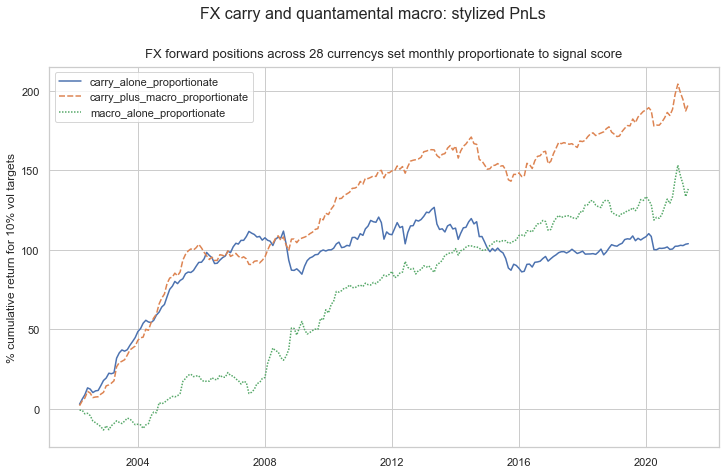

In [327]:
dfm_pnl = dfm_ppnl.copy()
dfm_pnl['value'] = dfm_pnl.groupby(['cat']).cumsum()

sns.set(rc={'figure.figsize':(12, 7)}, style = 'whitegrid')
ax = sns.lineplot(data=dfm_pnl, x='real_date', y='value', hue='cat', style='cat')
ax.set_xlabel('')
ax.set_ylabel('% cumulative return for 10% vol targets')
ax.legend_.set_title(None)
plt.suptitle('FX carry and quantamental macro: stylized PnLs', y=1, fontsize=16)
plt.title('FX forward positions across 28 currencys set monthly proportionate to signal score', y=1.01, fontsize=13)
plt.show()

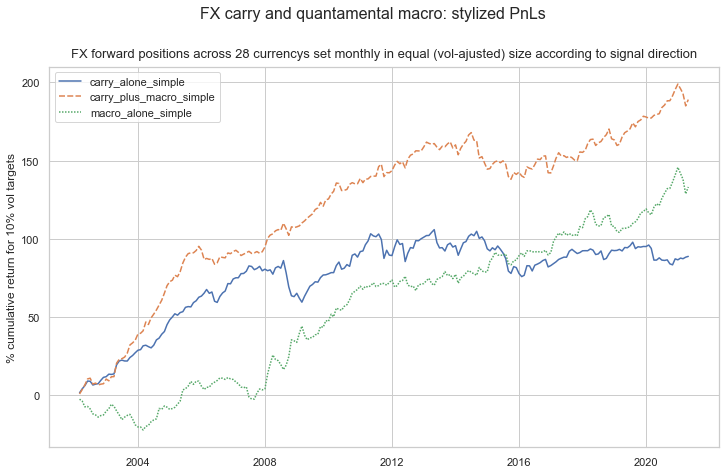

In [328]:
dfm_pnl = dfm_dpnl.copy()
dfm_pnl['value'] = dfm_pnl.groupby(['cat']).cumsum()

sns.set(rc={'figure.figsize':(12, 7)}, style = 'whitegrid')
ax = sns.lineplot(data=dfm_pnl, x='real_date', y='value', hue='cat', style='cat')
ax.set_xlabel('')
ax.set_ylabel('% cumulative return for 10% vol targets')
ax.legend_.set_title(None)
plt.suptitle('FX carry and quantamental macro: stylized PnLs', y=1, fontsize=16)
plt.title('FX forward positions across 28 currencys set monthly in equal (vol-ajusted) size according to signal direction', y=1.01, fontsize=13)
plt.show()